Взять с прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель

In [3]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

In [4]:
international_airline_passengers = pd.read_csv("Series/international-airline-passengers.csv")
female_births = pd.read_csv("Series/daily-total-female-births-in-cal.csv")

In [5]:
all_series = {
    "International airline passengers: monthly totals in thousands": international_airline_passengers["Count"],
    "Daily total female births in California": female_births["Count"]
}

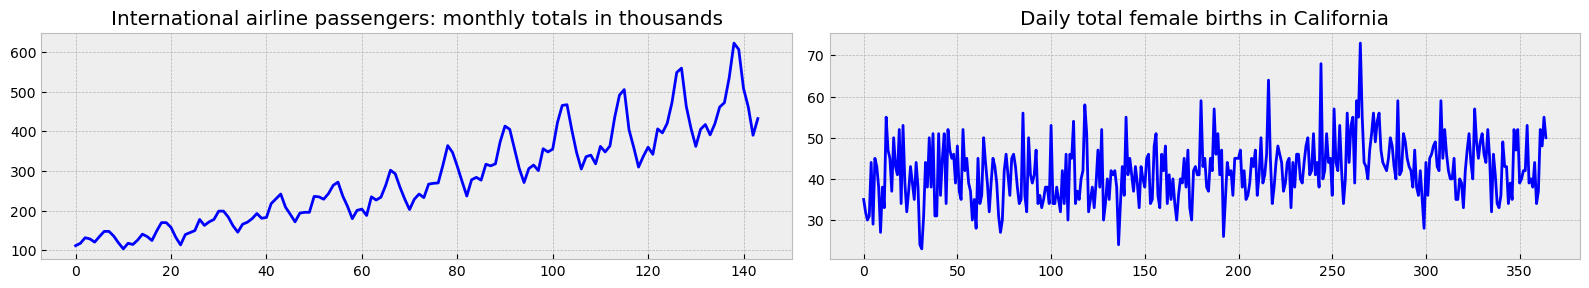

In [6]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()

Функции для проверки стационарности:

In [7]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [8]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

# 1. international airline passengers

###### Проверяем на стационарность ряд без обработки

In [8]:
series = pd.read_csv("Series/international-airline-passengers.csv")['Count']

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


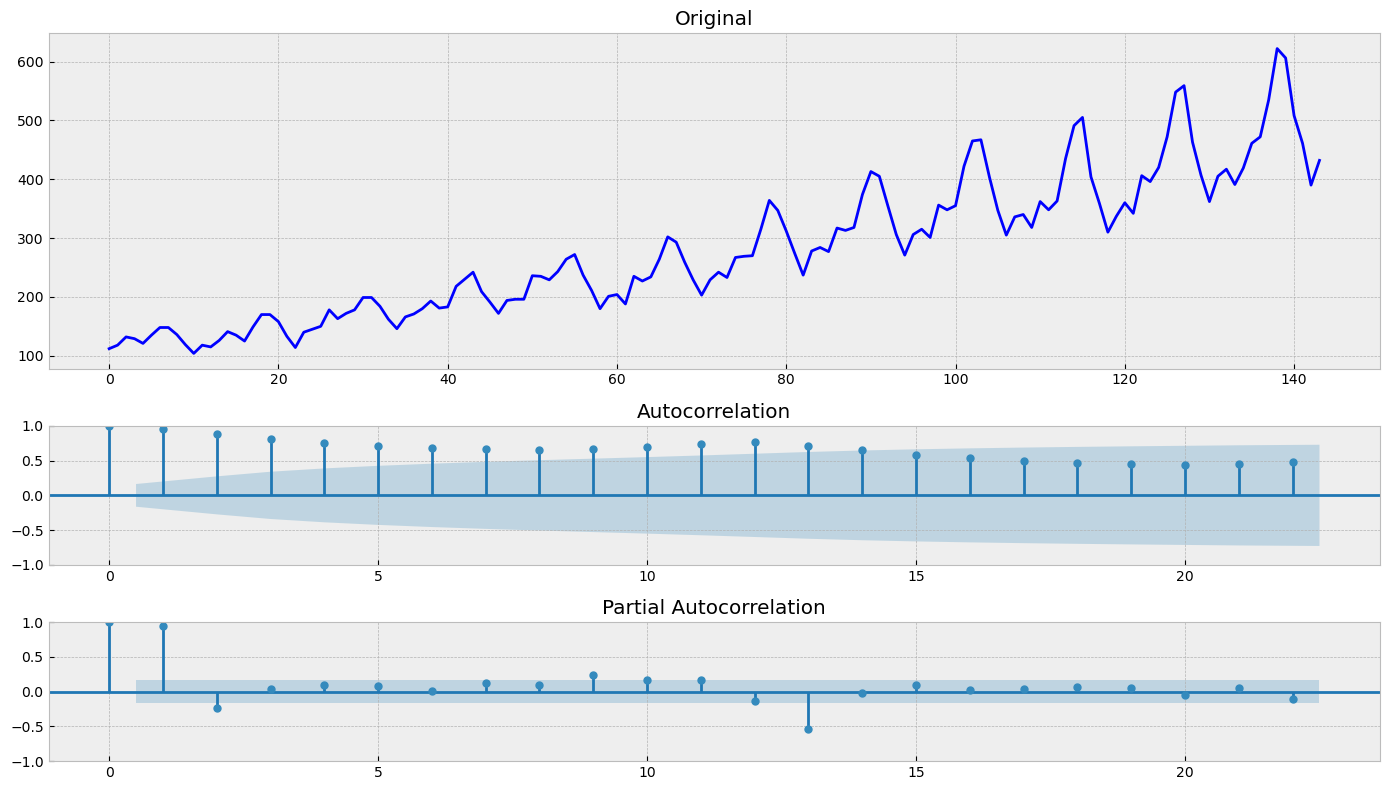

In [9]:
tsplot(series) #если p-value меньше чем 0.5, значит временной ряд стационарен

Не стационарный временной ряд.

Тут есть тренд и сезонность. Значит, для предсказания можем использовать тройное экспоненциальное сглаживание.

In [10]:
def initial_trend(series, season_len): #оцениваем первые три компоненты, с которых рекурсивная формула начнётся
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [11]:
def initial_seasonal_components(series, slen): #оцениваем первые три компоненты, с которых рекурсивная формула начнётся
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [12]:
#тройное экспоненциальное сглаживание
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [13]:
train, val = series[:65], series[65:]

In [35]:
from sklearn.model_selection import TimeSeriesSplit
#ошибку mse по трем параметрам считаем
def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
#         print(train_split_ts)
#         print(test_split_ts)
        result = triple_exponential_smoothing(train_split_ts, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
#    print(f'{np.mean(np.array(errors))}------------')
    return np.mean(np.array(errors))

In [20]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [37]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="BFGS", bounds = ((0, 1), (0, 1), (0, 1)))
#попробовала Nelder-Mead, но там ошибка 630 была
#L-BFGS-B - 175
#powell - 270
#CG (алгоритм сопряженных градиентов) - 162 очень долгий
#BFGS - 160 - лучший
#TNC - 175
#COBYLA - 190
#SLSQP - 175 быстро
#trust-constr - 163

D:\progr\Anaconda\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


In [38]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(alpha_opt, beta_opt, gamma_opt) 

0.0008101814640325271 35.62640442828556 0.09519903283321773


In [39]:
def plot_tema(alpha, beta, gamma, ser=international_airline_passengers["Count"], ser_to_plot=international_airline_passengers["Count"], n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

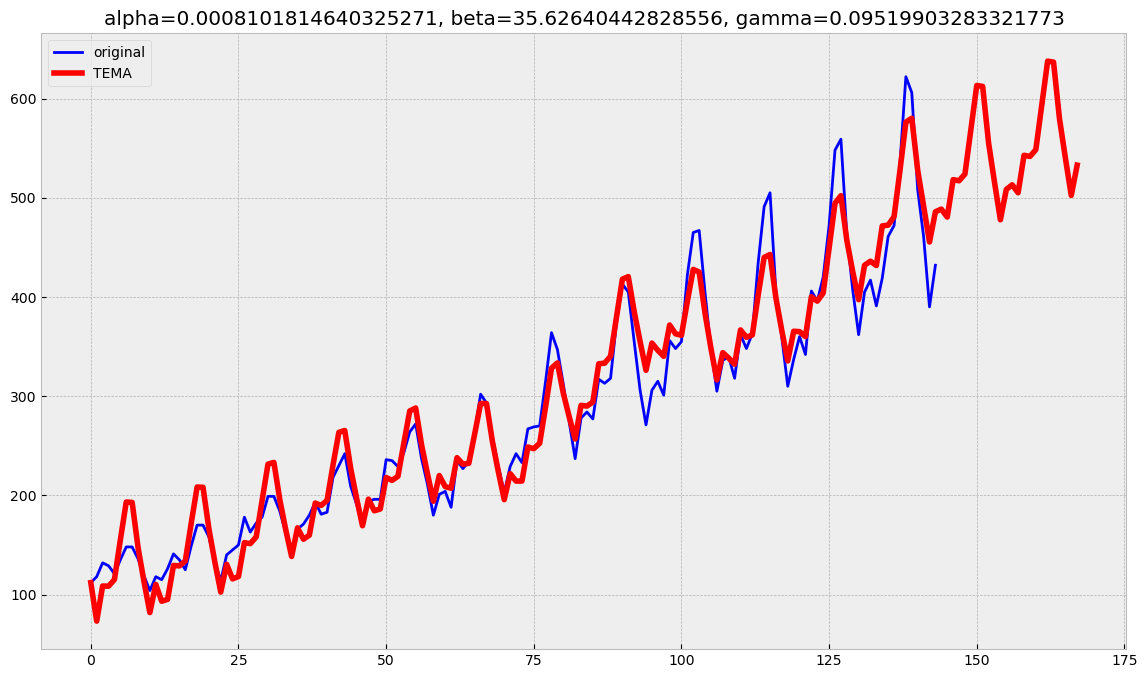

In [40]:
plot_tema(alpha_opt, beta_opt, gamma_opt)

Практически идеально!

На рандом тоже посмотрю, что получается:

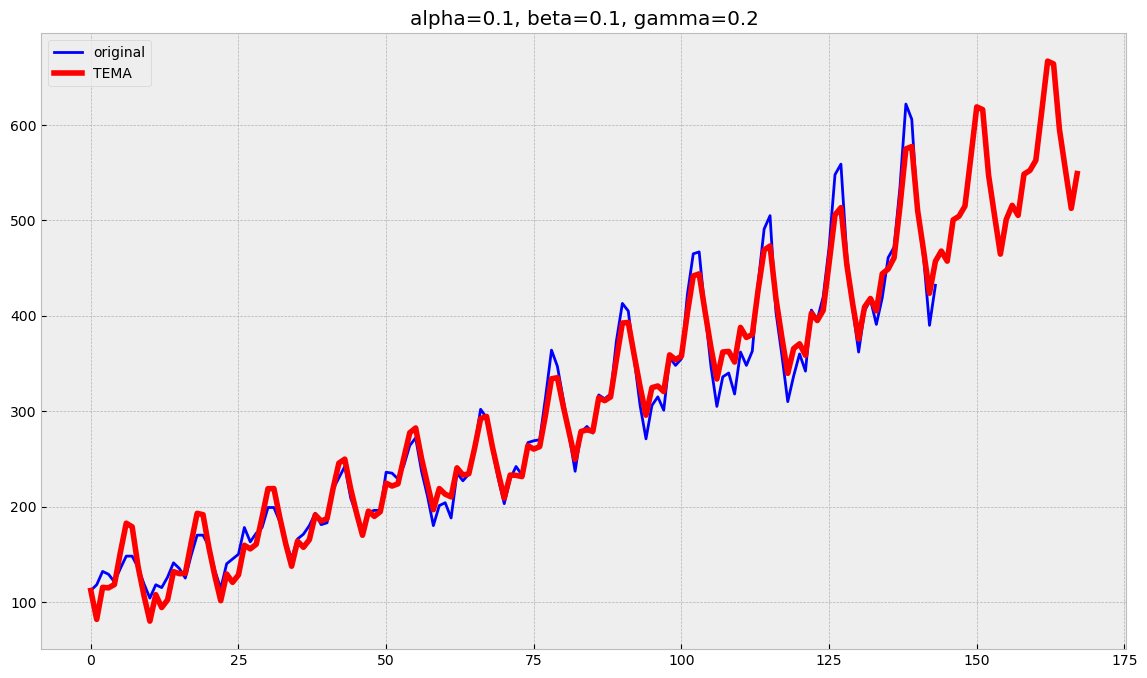

In [41]:
plot_tema(0.1, 0.1, 0.2)

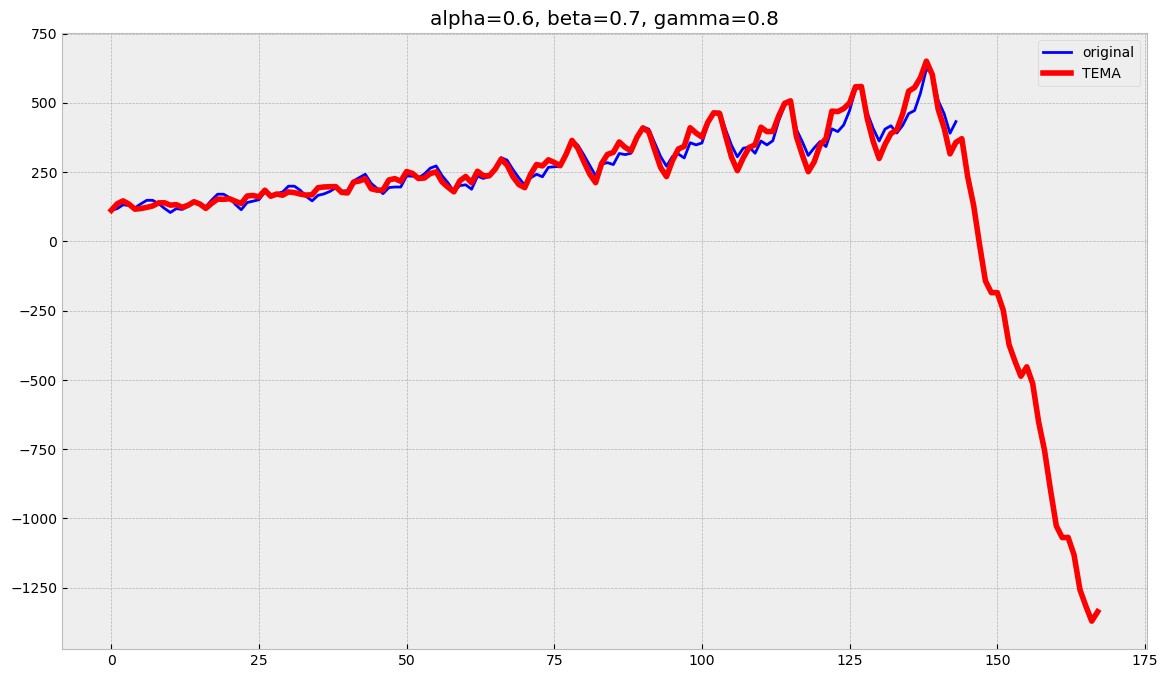

In [42]:
plot_tema(0.6, 0.7, 0.8)

Плохо, падает куда-то вниз.

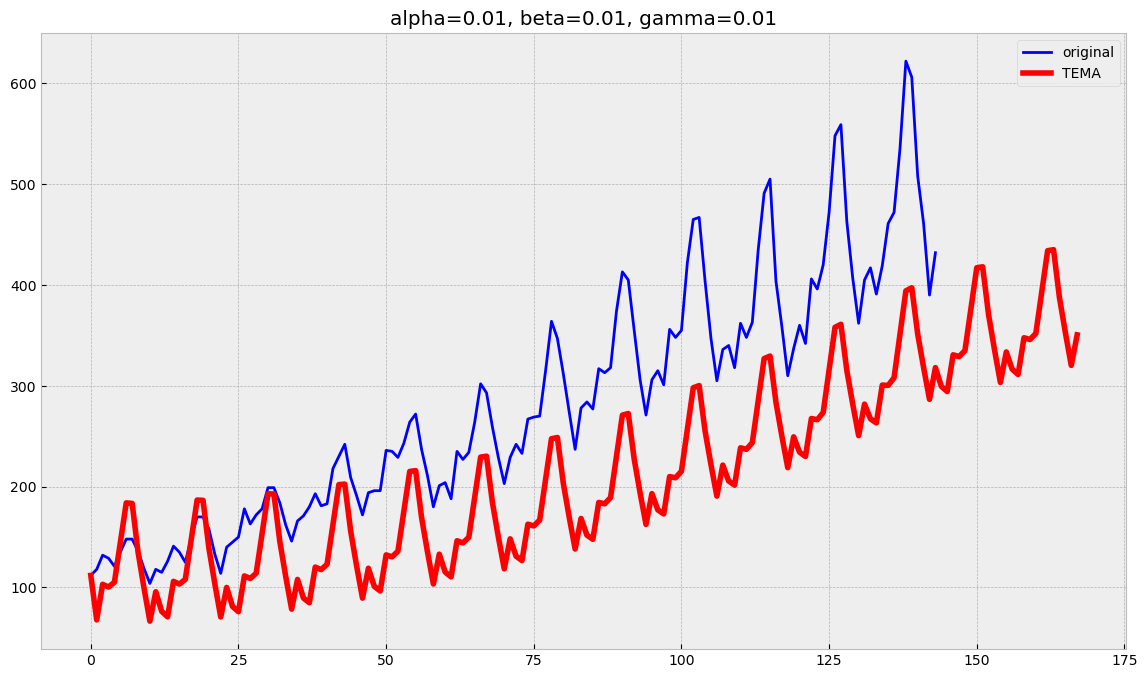

In [43]:
plot_tema(0.01, 0.01, 0.01)

Тоже плохо, тренд сильно ниже тренда реального графика.

# 2.Daily total female births in California

Results of Dickey-Fuller Test:
Test Statistic                  -4.808291
p-value                          0.000052
#Lags Used                       6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


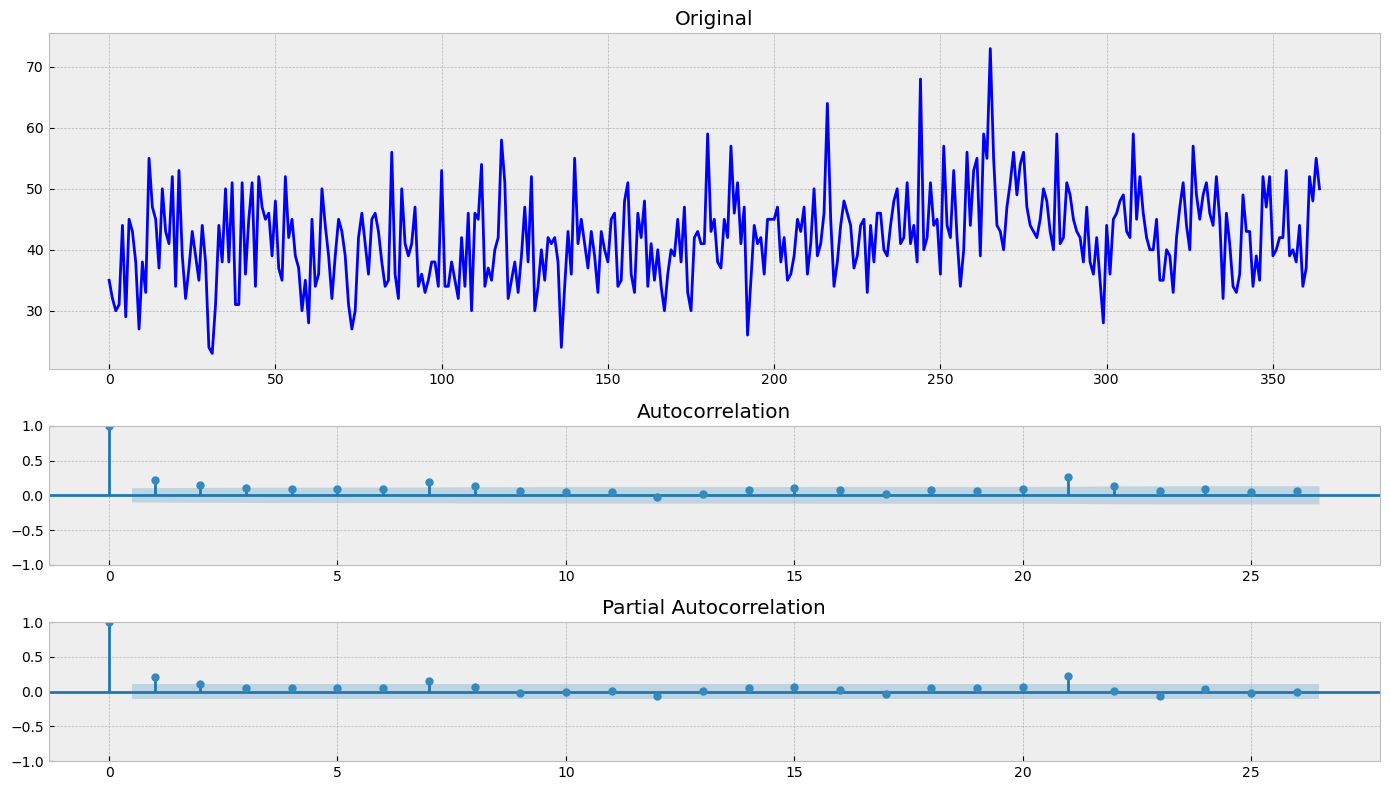

In [9]:
series = pd.read_csv("Series/daily-total-female-births-in-cal.csv")['Count']
tsplot(series)

Стационарный временной ряд. Можно использовать хоть взвешенное скользящее среднее, так как нет тренда, сезонности, цикличности.

In [84]:
def moving_average(series, n): #функция для скользящего среднего
    if not isinstance(series, pd.Series): #проверяем, что серис (временной ряд) является пандас серией
        series = pd.Series(series) #если не является, приводим к пандасу
    return series.rolling(n).mean() #у временного ряда вызываем метод rolling, который возвращает
                                    #n-размер окна, проходится этим окном по временному ряду
                                    #mean усредняет каждую строку окна [123], [234] и т.д

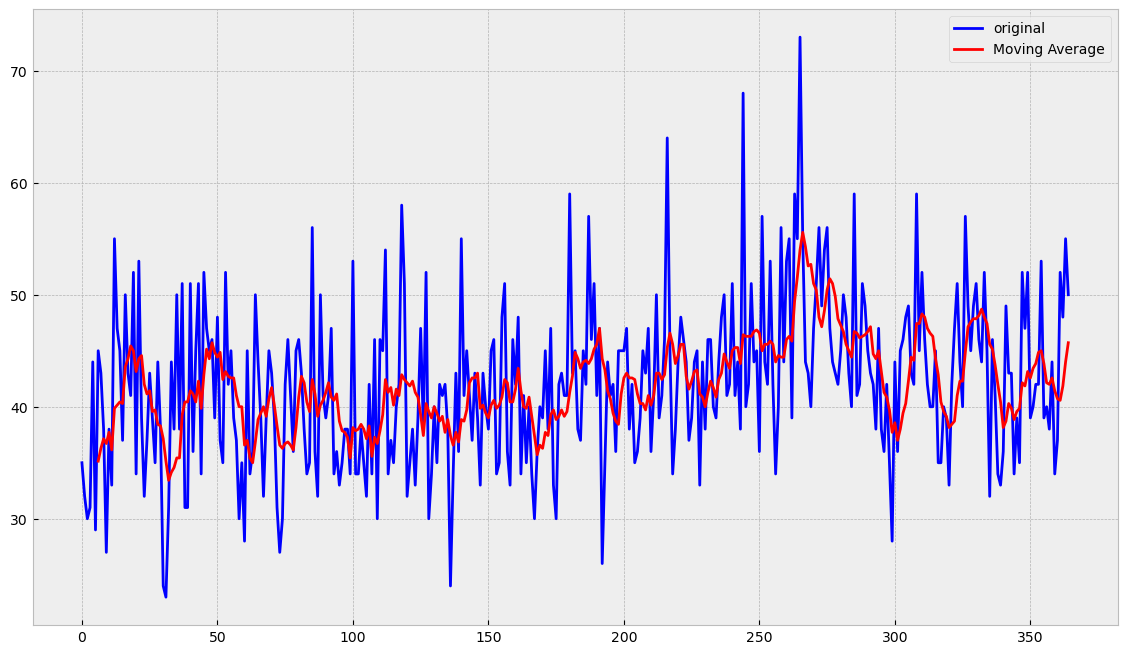

In [94]:
ser = moving_average(female_births["Count"], 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(female_births["Count"], color='blue',label='original')
    plt.plot(ser, color='red', linewidth='2', label='Moving Average')
    plt.legend()

In [87]:
def predict(series, N, n_pred):
    new_series = series.copy()
    for _ in range(n_pred):
        new_series = new_series._append(pd.Series([new_series[-N:].mean()]), ignore_index=True)
    return new_series

In [89]:
series_pred = predict(female_births["Count"], 7, 50)

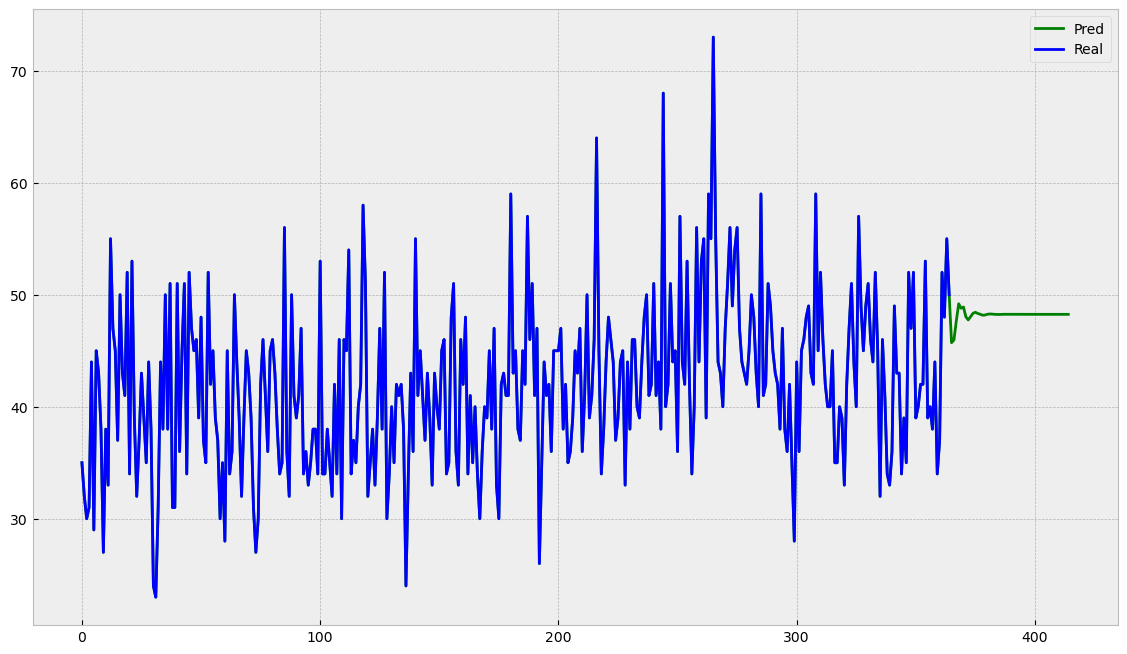

In [93]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_pred, color='green', linewidth='2', label='Pred')
    plt.plot(female_births["Count"], color='blue', linewidth='2', label='Real')
    plt.legend()

Другим способом предскажем:

In [15]:
n_predict = 20
train = pd.Series(all_series["Daily total female births in California"][:len(all_series["Daily total female births in California"])-n_predict])
test = pd.Series(all_series["Daily total female births in California"][len(all_series["Daily total female births in California"])-n_predict:])

     

In [16]:
def exponential_moving_average(series, alpha, n_pred):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n-1] + (1 - alpha) * result[n-1])
    if not n_pred:
        return pd.Series(result)
    
    predictions = [alpha * series[len(series) - 1] + (1 - alpha) * result[-1]]

    for _ in range(n_pred):
        res = alpha * predictions[-1] + (1 - alpha) * result[-1]
        result.append(res)
        predictions.append(res)
    
    return series._append(pd.Series(predictions), ignore_index=True), pd.Series(result)
     

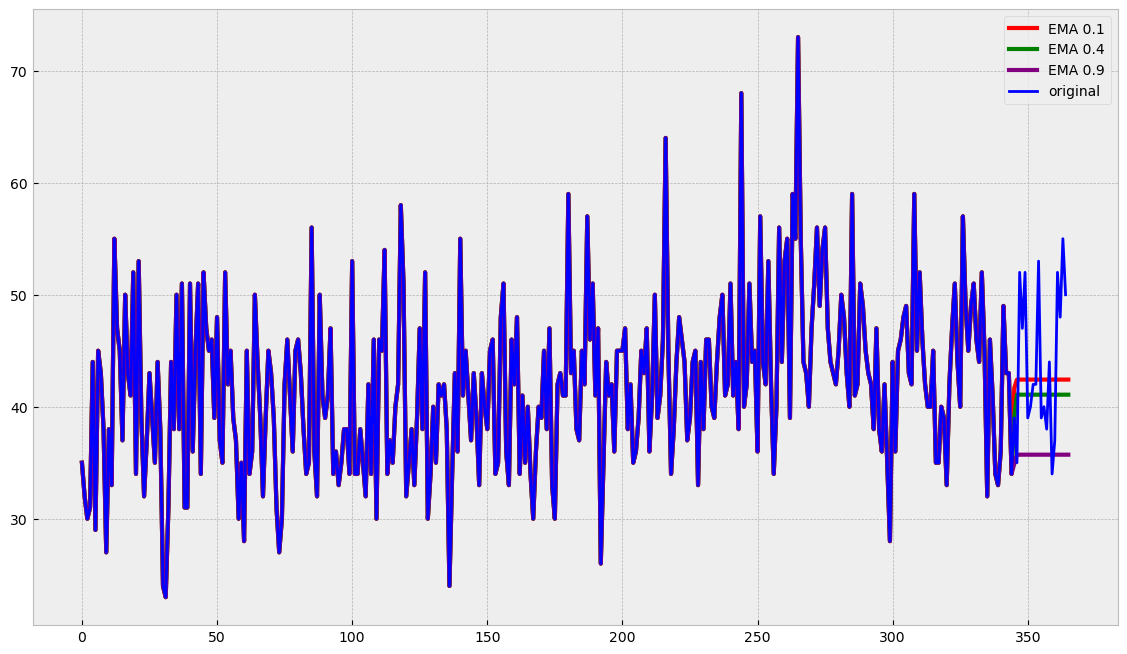

In [25]:

alphas = [0.1,0.4,0.9]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    for i in range(len(alphas)):
        ser, _ = exponential_moving_average(train, alphas[i], len(test))
        plt.plot(ser, color=colors[i], linewidth='3', label='EMA {}'.format(alphas[i]))
    plt.plot(all_series["Daily total female births in California"], color='blue',label='original')
    plt.legend()

In [31]:
ser[len(test):]

20     34.000000
21     53.000000
22     39.000000
23     32.000000
24     37.000000
         ...    
361    35.718876
362    35.718876
363    35.718876
364    35.718876
365    35.718876
Length: 346, dtype: float64

In [33]:
mean_squared_error(ser[-len(test):], test)
     

108.72078497853136

##### Вывод: 
Модель Хольт-Винтерса отлично работает, особенно если сделать автоматический подбор оптимальных параметров. Однако этого не скажешь про другие модели класса MA. 

MSE в модели Хольта-Винтерса при разбросе значений от 100 до 620: 160

MSE в модели с использованием взвешенного скользящего среднего при значениях от 20 до 80: 108